In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
import matplotlib.pylab as plt
import numpy as np
from mgemu import emu
import pyccl

In [3]:
#import MAS_library as MASL
#import Pk_library as PKL

In [4]:
def pmg(Om, h, ns, s8, fR0, n, z):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    gc.collect()
    # cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    return pk_mg, k

In [5]:
#Defining function to calculate galaxy power spectrum, using the matter Pk from function pmg
#Additional arguments needed are linear bias b1& snot noise term shot
def p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot):
    Omh2 = (h**2)*Om
    pkratio, k = emu(Omh2, ns, s8, fR0, n, z)
    gc.collect()
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert k-emu range
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    pgg_mg = b1*b1*pk_mg + shot
    return pgg_mg, k

In [6]:
### LCDM parameters
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0

In [7]:
np.random.randint(1e5, size=1)

array([3106])

In [8]:
pkratio , k = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=0.031)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [8]:
#pkratio

In [9]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmo = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))
a = 1./(1+z)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, a)
pk_lcdm *= h*h*h

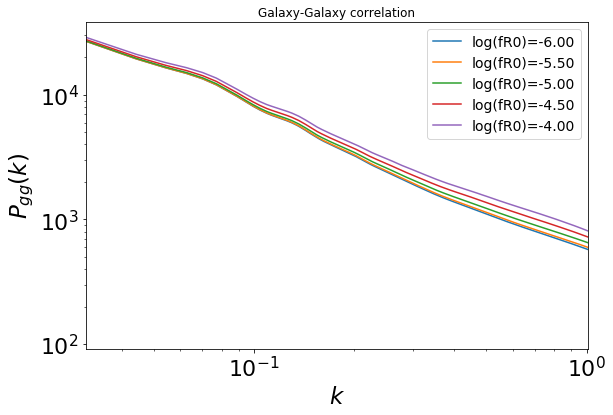

In [10]:
import matplotlib.pylab as plt
import numpy as np

plt.figure(1, figsize=(9, 6) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
b1 =1.2
shot = 10.0
for i in range(5):
    fR0 = fR0_arr[i]
    #p_mg, k = pmg(Om, h, ns, s8, fR0, n, z)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.title('Galaxy-Galaxy correlation')
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [11]:
#Now that we can evalute the galaxy Pk for a given MG cosmology, let's build functions to actually predict the galaxy bias and shot noise for a realistic LSST sample 

In [9]:
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad
from scipy.special import gamma
from scipy.integrate import odeint

In [10]:
#Define a-dependent functions for growth factor equation
def Omegatime(a, Om0):
 return Om0/(Om0+(1-Om0)*a*a*a)
#adot
def adot(a, Om0):
 return np.sqrt(Om0/a+(1-Om0)*a*a)
def H(a, Om0):
 return adot(a, Om0)/a
def adotprime(a, Om0):
 return (-Om0/a/a + 2*(1-Om0)*a)/np.sqrt(Om0/a+(1-Om0)*a*a)/2
#Define additional functions needed for
def mfr(a, Om0, fr0, nfr): #scalar field mass
 return (1/2997.72)*math.sqrt(1./(nfr+1)/fr0)*math.sqrt(math.pow(Om0+4*(1-Om0),-nfr-1))*math.sqrt(math.pow(Om0/a/a/a+4*(1-Om0),2+nfr))
#Define 1/adot^3 integrand
def invadot3(a, Om0):
 return 1/adot(a, Om0)/adot(a, Om0)/adot(a, Om0)
#Define 1/adot^3 integral
def intToday(Om0, amin):
 return quad(invadot3,0,amin,args=(Om0))[0]
def Damin(Om0, amin):
 return 2.5*Om0*H(amin, Om0)*intToday(Om0, amin)
def DH1(a, Om0):
 return -3*Om0/(2*a*a*a*math.sqrt((a*a*a+Om0-Om0*a*a*a)/a))
def der0(Om0, amin):
 return 2.5*Om0*(DH1(amin, Om0)*intToday(Om0, amin)+H(amin, Om0)*invadot3(amin, Om0))

In [11]:
#Setup integration to get comoving volume for various z bin
#Comoving distance integrator
def integrand(a, Omm):
 return 1/math.sqrt(a*Omm+a*a*a*a*(1-Omm))
#get comoving volume
def Vcom(z, Omm):
 return (4*math.pi*20000)/(3*41252.96)*math.pow(2997.92458*quad(integrand, 1./(1+z), 1, args=(Omm))[0],3)#*math.pow(10,-9)
#get comoving differential volume in redshift bin with width +-0.05
def Vbin(z, Omm, bin):
 return Vcom(z+bin, Omm)-Vcom(z-bin, Omm)
Veff=np.vectorize(Vbin)

#Define function fro differential dN/dz to be integrated
def dNdz(z, alpha, z0, ntot):
 return (ntot*alpha/(z0*gamma(3.0/alpha)))*(z/z0)*(z/z0)*math.exp(-math.pow(z/z0,alpha))
def Nz(z, alpha, z0, ntot, bin):
 return quad(dNdz, z-bin, z+bin, args=(alpha, z0, ntot))[0]

In [15]:
#Setup basic parameters for year10&Y1 LSST photo-z samples
NY10=48*20000*3600
ay10= 0.90
z0y10 = 0.28
biny10 = 0.05
b1y10 = 0.95
#for year1 sample
NY1=18*20000*3600
ay1= 0.94
z0y1 = 0.26
biny1 = 0.1
b1y1 = 1.05

In [16]:
abserr = 1.0e-13
relerr = 1.0e-13
#Define growth factor differential equation system
def growth(y, a, Om0):
 D, w = y
 dyda = [w, -(adotprime(a, Om0) + 2*H(a, Om0))*w/adot(a, Om0) + 1.5*Omegatime(a, Om0)*H(a, Om0)*H(a, Om0)*D/adot(a, Om0)/adot(a, Om0)]
 return dyda
 
#y0 = [0.0019999999,0.999999999]
arange = np.logspace(math.log(0.002,10),math.log(1,10),1000)
#setting up boundary conditions
y0 = [Damin(Om, arange[0]),der0(Om, arange[0])]
sol = odeint(growth, y0, arange, args=(Om,), atol=abserr, rtol=relerr)
#Spline GR growth factor  solution and growth rate.
Dgr = interp1d(arange, sol[:,0], kind='cubic')
#and also growth rate
fgr = interp1d(arange, arange*sol[:,1]/sol[:,0], kind='cubic')

In [17]:
timesteps = np.loadtxt('timestepsCOLA.txt')
irangey10 = np.array([43,45,48,53,57,61,65,70,75,82])
irangey1 = np.array([43,48,57,65,75])
Nt = irangey10[irangey10.shape[0]-1]

Nseed=2000 #25

In [18]:
#Now iterate of different snapshots
for i in (irangey10):
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case Y10
 b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y10
 print ('a,z,b_1=',astep, zstep, b1)

a,z,b_1= 0.4512 1.216313 1.7096583337348537
a,z,b_1= 0.4708 1.124045 1.645654696216662
a,z,b_1= 0.5002 0.999201 1.5599659653732123
a,z,b_1= 0.5492 0.820831 1.439767025161971
a,z,b_1= 0.5884 0.699524 1.359885641811489
a,z,b_1= 0.6276 0.593372 1.2915087247085706
a,z,b_1= 0.6668 0.4997 1.232567867300583
a,z,b_1= 0.7158 0.397038 1.169726499808988
a,z,b_1= 0.7648 0.307531 1.1166678302825346
a,z,b_1= 0.8334 0.199904 1.0553364364635174


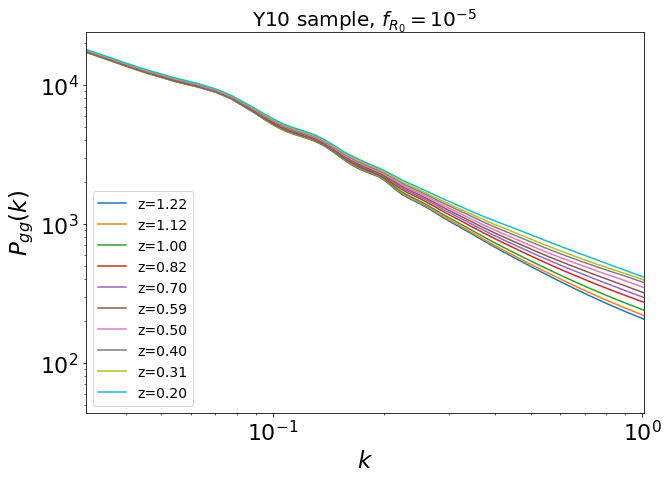

In [19]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, zstep, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
plt.xscale('log')
plt.yscale('log')
#plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.title(r'Y10 sample, $f_{R_0}=10^{-5}$', fontsize=20)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [20]:
#print (Nseed, k.shape[0],((Nseed-k.shape[0]-2)/(Nseed-1)))
#Import covariance matrices
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    locals()['covPMGmat_'+str(i)] = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    locals()['InvcovPMGmat_'+str(i)] = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(locals()['covPMGmat_'+str(i)])
    

In [21]:
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    print (zstep)

1.216313
1.124045
0.999201
0.820831
0.699524
0.593372
0.4997
0.397038
0.307531
0.199904


In [22]:
kvec = k
def applyPlotStyle14():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 plt.grid(True)
 plt.xscale("log")
 plt.yscale("log")
 plt.xlim(kvec[0], 0.6)
 plt.ylim(kvec[0], 0.6)
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=20)
 plt.ylabel(r"$k (h/Mpc)$",fontsize=20)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

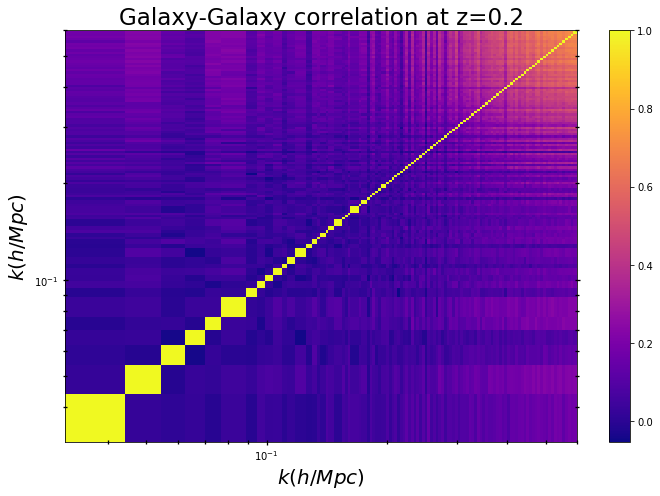

In [23]:
#Get correlation matrix for step=43
covxx = np.sqrt(np.diag(covPMGmat_82))*np.identity(len(kvec))
invcoxx = np.linalg.inv(covxx)
corrPMGmat_43 = np.dot(invcoxx,np.dot(covPMGmat_82,invcoxx))
import scipy.ndimage as scim
#sigma_x = sigma_y = 2.0
#sigma = [sigma_y, sigma_x]
#cov_mat2 = scim.filters.gaussian_filter(covPMGmat_82, sigma, mode='wrap')
#covxxsmopth = np.sqrt(np.diag(cov_mat2))*np.identity(len(kvec))
#invcov_mat2 = np.linalg.inv(covxxsmopth)
#corr_mat2 = np.dot(invcov_mat2,np.dot(cov_mat2,invcov_mat2))
ii = np.where(kvec<0.6)
from matplotlib import gridspec
from matplotlib import cm
fig11=plt.figure('test', figsize=(10, 7) )
ax=fig11.add_subplot(111)
applyPlotStyle14()
ax.set_title('Galaxy-Galaxy correlation at z=0.2', fontsize=23)
#pltcov=ax.pcolormesh(kvec,kvec,covPMGmat_82, cmap='plasma')
pltcov=ax.pcolormesh(kvec[ii],kvec[ii],corrPMGmat_43[0:101,0:101], cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,corr_mat2, cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,cov_mat2, cmap='plasma')
fig11.colorbar(pltcov, ax=ax)
plt.tight_layout()
plt.show()

In [24]:
ii

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),)

In [43]:
npar = 6 #no of paramaters to constrain
FY10tot = np.zeros([npar,npar])
FY1tot = np.zeros([npar,npar])
imax =  47 #135 #maximum k scale array index
#imax = 21

In [37]:
#Setup integration to get Fisher matrix using Tegmark's analytical formula
#Integrand
#def integrandFisher(kk, derD1, derD2, D, kvec):
 #construct splines of vectors, to make integrator happy
# der1int = interp1d(kvec, derD1, kind='cubic')
# der2int = interp1d(kvec, derD2, kind='cubic')
# Pfidint = interp1d(kvec, D, kind='cubic')    
# return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
#integrandFisher = np.vectorize(integrandFisher)
#Quadrature
#def Fisher_gaussian(derD1, derD2, D, kvec, imax):
# return quad(integrandFisher, kvec[0], kvec[imax], args=(derD1, derD2, D, kvec))[0]#*math.pow(10,-9)
#Fisher_gaussian = np.vectorize(Fisher_gaussian)
print (kvec[0:imax])

[0.0312147  0.0442523  0.054388   0.06273525 0.07010365 0.0771044
 0.08893805 0.0947648  0.099384   0.10422835 0.10930885 0.1128327
 0.11833265 0.1260851  0.1301498  0.1343455  0.1364938  0.14089405
 0.14314705 0.14776175 0.15496425 0.15744225 0.1599599  0.1625178
 0.1704396  0.17316505 0.1787475  0.1816058  0.18450985 0.18746035
 0.190458   0.1935036  0.19974165 0.2029357  0.20618085 0.2094779
 0.21282765 0.21623095 0.21968865 0.22320165 0.22677085 0.23039715
 0.23408145 0.2378246  0.2416276  0.24549145 0.2494171 ]


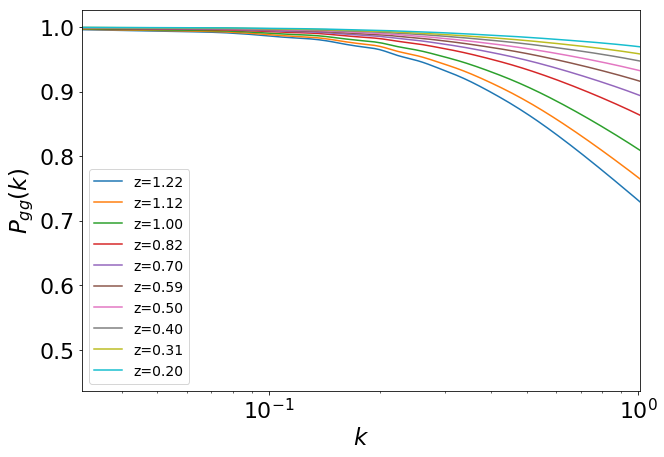

In [27]:
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    nlit = 1.0/Shot
    plt.plot(kkk, (nlit*Pfid)*(nlit*Pfid)/(1.0+nlit*Pfid)/(1.0+nlit*Pfid), label = "z={:.2f}".format(zstep) )
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [46]:
#Calculating derivatives for Y10 sample

#Omstep = 0.003
#s8step = 0.05 #0.05
#nsstep = 0.03 #0.025
#fr0step = fr0*0.1
#nstep = 0.1*n
#b1step=0.01
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(82,83):
#for i in (irangey10):
for i in (irangey10[5:10]):    
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    ndens = 1.0/Shot
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny10)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y10*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y10*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    #import scipy.ndimage as scim
    #sigma_x = sigma_y = 2.0
    #sigma = [sigma_y, sigma_x]
    #cov_matsmooth = scim.filters.gaussian_filter(covPMGmatz, sigma, mode='wrap')
    #InvcovPMGmatz = ((Nseed-kvec.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    #InvcovPMGmatz = ((Nseed-kvec.shape[0]-2)/(Nseed-1))*np.linalg.inv(cov_matsmooth)[0:imax,0:imax]
    #Diagonal approximation, temporary test
    #covPMGmatz = np.diag(covPMGmat_82)*np.identity(len(kvec))
    #InvcovPMGmatz = np.linalg.inv(covPMGmatz[0:imax,0:imax])
    dertot = dertot.T 
    #loop over all parameters to populate it    
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy 
         Vk = (ndens*Pfidint(kk))*(ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))
         return kk*kk*der1int(kk)*der2int(kk)*Vk/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY10tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [47]:
#FY10tot

In [49]:
#FY10tot
np.savetxt('./Covariance_data/FisherzY10analhalfzk025.txt', FY10tot)

In [ ]:
#dertot = dertot.T
#print (dertot[:,0].shape)
#print (dertot)
#FisheTest = np.dot(dertot[:,3],np.dot(InvcovPMGmat_43,dertot[:,3]))
#print (k[0:60])
print (np.sqrt(np.linalg.inv(FY10tot)[3,3]))
#print (np.linalg.inv(FY10tot)[3,3])
#covPMGmatztest = np.loadtxt('./Covariance_data/covariance_step_43.txt')
#Inv1 = np.linalg.inv(covPMGmatztest[0:imax,0:imax])
#Inv2 = np.linalg.inv(covPMGmatztest)[0:imax,0:imax]
#print (Inv1/Inv2)
#print (((Nseed-k.shape[0]-2)/(Nseed-1))/((Nseed-60-2)/(Nseed-1)))
#print ((Nseed-imax-2)/(Nseed-1))

In [ ]:
fig = plt.figure('dertest')
print (zstep)
fr0up = fr0 + fr0step
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0step
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='r')
plt.semilogx(k,dertot[:,4])
plt.semilogx(k,dertot[:,4])
plt.show()

In [ ]:
fig = plt.figure('frtest')
#zstep = 
fr0stepint = fr0*0.01
fr0up = fr0 + fr0stepint
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0stepint
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
astep = 1./(1+zstep)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, astep)
pk_lcdm *= h*h*h
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='b')
#plt.semilogx(k,fr0*(p_ggup-p_ggdown)/(fr0stepint*2))
#plt.semilogx(k,(p_ggup/p_ggdown))
plt.semilogx(k,(p_ggdown/pk_lcdm))
#plt.semilogx(k,dertot[:,3])
plt.show()

In [ ]:
np.savetxt('./Covariance_data/FisherzY10smoothk03.txt', FY10tot)

In [ ]:
#Repeating previous calculation for Y1 sample
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(43,44):
for i in (irangey1):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y1
    b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y1
    Shot = Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny1)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y1*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y1*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covarianceY1_step_'+str(i)+'.txt')
    #InvcovPMGmatz = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    dertot = dertot.T
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy   
         return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY1tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [ ]:
np.savetxt('./Covariance_data/FisherzY1analk03.txt', FY1tot)

In [ ]:
print (FY1tot)

In [ ]:
h_l = 0.67
Om_l = 0.3000
Omb_l = 0.0260
s8_l = 0.8200
ns_l=0.9600
print (Om_l-Omb_l)
#a = 1./(1+z)
#Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
#kccl = k*h
#pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)


In [ ]:
kl, Pk97 = np.loadtxt('/Users/gev866/Downloads/Pk_97.txt', unpack=True)
kl, Pk71 = np.loadtxt('/Users/gev866/Downloads/Pk_71.txt', unpack=True)
kl, Pk36 = np.loadtxt('/Users/gev866/Downloads/Pk_36.txt', unpack=True)
#print (kl, Pk97)
a97=1.0/(1.0+0.019)
#cosmo_l = pyccl.Cosmology(Omega_c=Om_l-Omb_l, Omega_b=Omb_l, h=h_l, sigma8=s8_l, n_s=ns_l, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
pk_emu = pyccl.nonlin_matter_power(cosmo, kl, a97)

In [ ]:
plt.figure('testing', figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('COLA simulations')
plt.plot(kl/h_l, Pk97, label = r'$z=0.02$', color='b')
plt.plot(kl/h_l, Pk71, label = r'$z=0.38$', color='r')
plt.plot(kl/h_l, Pk36, label = r'$z=1.62$', color='g')
plt.plot(kl/h_l, pk_emu*h_l*h_l*h_l, label = 'CosmicEmu', color='c')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{m}(k)$', fontsize=23)
plt.xlabel(r'$k$ (h/Mpc)', fontsize=23)
plt.legend(fontsize=14)
#plt.xlim(0.035, 3.5)
#plt.ylim(1e3,)
plt.show()


In [24]:
nn=1

In [25]:
cov_mat= np.loadtxt('./Covariance_data/covariance_97_2000s.txt')
#sigma_x = sigma_y = 2.0
#sigma = [sigma_y, sigma_x]
#cov_mat = scim.filters.gaussian_filter(cov_matuns, sigma, mode='wrap')
#kz, pkratioz = np.loadtxt('./Covariance_data/ratioavg_97_2000s.txt', unpack=True)
pkratioz, kz = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=nn, z=0.0)# 

In [26]:
l, Cl = np.loadtxt('/Users/gev866/Downloads/Cl_test.txt', unpack=True)
l, Clavg10, Cerr10 = np.loadtxt('/Users/gev866/Downloads/Cl_avg5000.txt', unpack=True)
l, Cl10k, Cerr10k = np.loadtxt('/Users/gev866/Downloads/Cl_avg10000_new.txt', unpack=True)
l, Clavg, Cerr = np.loadtxt('/Users/gev866/Downloads/Cl_avg512new.txt', unpack=True)
l, Clavgold, Cerrold = np.loadtxt('/Users/gev866/Downloads/Cl_avg512.txt', unpack=True)
lzolt, ClZolt, CerrZolt = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt.txt', unpack=True)
lzolt2, ClZolt2, CerrZolt2 = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt_2.txt', unpack=True)
lzoltseed, ClZoltseed2, CerrZoltseed2 = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt_newseed.txt', unpack=True)
l, ClavgG, CerrG = np.loadtxt('/Users/gev866/Downloads/Cl_avg512Gadget_seed2.txt', unpack=True)
l, ClavgG1800, CerrG1800 = np.loadtxt('/Users/gev866/Downloads/Cl_avg512Gadget1800.txt', unpack=True)
#print (Clavg,l)

In [ ]:
100*((ClavgG1800/l/(l+1))/(ClZolt/l/(l+1))-1)


In [ ]:
z97 = timesteps[97,1]

In [ ]:
#pkratioz, kz = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=0.2)
print (math.pow(10,math.log(fr0,10)))

In [ ]:
kcondt = np.where(kz < 3.5)
print (cov_mat[0: np.array(kcondt)[0][-1] + 1, 0: np.array(kcondt)[0][-1] + 1].shape)

In [ ]:
from matplotlib import gridspec
from matplotlib import cm

In [ ]:

import time

In [ ]:
#New part to test Nesar's Fisher code
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.misc import derivative




def plot_contours(hessian, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = - hessian

  cov = np.linalg.pinv(mat)

  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip


def lnlike_k(theta, x, y, kcut):
    p1, p2, p3, p4, p5 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5])

    cov_mat_red = cov_mat[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    model, kdum = emu(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition  
    gc.collect()


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike


dtheta = 5e-3

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx = dtheta)


def hess_k(ind0, ind1, klim):

    def loglike(p, q):
        params = np.empty_like(fid_params)
        params[:] = fid_params
        params[ind0] = p
        params[ind1] = q

        return lnlike_k(params, kz, pkratioz, klim)

    def Dx(p, q):
        return partial_derivative(func=loglike, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglike, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_params[ind0], fid_params[ind1])
    h[1, 1] = Dyy(fid_params[ind0], fid_params[ind1])
    h[1, 0] = Dyx(fid_params[ind0], fid_params[ind1])
    h[0, 1] = Dxy(fid_params[ind0], fid_params[ind1])
    print(h)
    return h

def params_ell(ind0, ind1):
    params = np.array([fid_params[ind0], fid_params[ind1]])
    return params




In [ ]:
gsc=gridspec.GridSpec(5,5, wspace=0.0, hspace=0.0)
fid_params = np.array([Omh2,ns,s8,math.log(fr0,10),nn])
print (fid_params)
num_parameters = 5

In [ ]:


#fig, a = plt.subplots((num_parameters, num_parameters))
f, a = plt.subplots(num_parameters, num_parameters, figsize=(18, 18), sharex = 'col', sharey = 'row')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
Fisherfin = np.zeros(shape = (num_parameters,num_parameters))
for i in range(num_parameters):
    for j in range(num_parameters):
        print(i, j)
        if (i > j):
            sub = hess_k(j,i, 0.25)
            Fisherfin[j,j] = sub[0,0]
            Fisherfin[i,i] = sub[1,1]
            Fisherfin[j,i] = sub[0,1]
            Fisherfin[i,j] = sub[1,0]
            #plot_contours(sub, params_ell(j, i), fill=False, color = 'b', linewidth = 0.1)
            plot_contours(sub, params_ell(j, i), fill=True, ax = a[i, j], alpha=0.3, linewidth = 0.1)
            #plot_contours(hess_k(j,i, 0.15), params_ell(j, i), fill=True, ax = a[i, j], linewidth = 0.1)
            
plt.show()            

In [ ]:
FisherfinT = np.zeros(shape = (num_parameters,num_parameters))
start = time.time()
for i in range(num_parameters):
    for j in range(num_parameters):
        print(i, j)
        if (i > j):
            sub = hess_k(j,i, 0.25)
            FisherfinT[i,i] = sub[0,0]
            FisherfinT[j,j] = sub[1,1]
            FisherfinT[i,j] = sub[0,1]
            FisherfinT[j,i] = sub[1,0]
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)

In [ ]:
#np.savetxt('./Covariance_data/FisherHessz97.txt', -Fisherfin)
np.savetxt('./Covariance_data/FisherHessz97Smooth.txt', -Fisherfin)

In [ ]:
np.savetxt('./Covariance_data/FisherHessz97T.txt', -FisherfinT)

In [ ]:
print (np.diag(np.linalg.pinv(-Fisherfin[0:5,0:5])))

In [ ]:
print (np.diag(np.linalg.pinv(-Fisherfin)))

In [ ]:
#import sys
#!{sys.executable} -m pip install camb --user
#!{sys.executable} -m pip install git+https://github.com/lgarrison/asdf.git abacusutils --user

In [ ]:
def lnlike_kgal(theta, x, y, kcut, zz, Cov, shot):
    p1, p2, p3, p4, p5, p6 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5, p6])

    cov_mat_red = Cov[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    #model, kdum = emu(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition 
    #print (p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, 0)
    model, kdum  =  p_ggmg(p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, shot)
    gc.collect()
    


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [ ]:
#Define new function for the Loglikehood and Hessian, based on Nesar code, but now for P_gg
def hess_kgal(ind0, ind1, klim, fid_arr, kz, pkratioz, zz, Cov, shot):

    def loglikegal(p, q):
        params = np.empty_like(fid_arr)
        params[:] = fid_arr
        params[ind0] = p
        params[ind1] = q

        return lnlike_kgal(params, kz, pkratioz, klim, zz, Cov, shot)

    def Dx(p, q):
        return partial_derivative(func=loglikegal, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglikegal, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_arr[ind0], fid_arr[ind1])
    h[1, 1] = Dyy(fid_arr[ind0], fid_arr[ind1])
    h[1, 0] = Dyx(fid_arr[ind0], fid_arr[ind1])
    #h[0, 1] = Dxy(fid_arr[ind0], fid_arr[ind1])
    h[0, 1] = h[1, 0]
    #print(h)
    return h

In [ ]:
#Loop over various snapshots of the Y10 sample
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
numpar = 6
FY10new = np.zeros([numpar,numpar])
kmax = 0.25
start = time.time()
for k in (irangey10[8:9]):
#for k in (irangey10):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    #ndens = 1.0/Shot
    param_array = np.array([Omh2,ns,s8,fr0log,n,b1])
    #print (param_array)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot)
    gc.collect()
    covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(k)+'.txt')
    for i in range(numpar):
     for j in range(numpar):
      #print(i, j)
      if (i > j):
        sub = hess_kgal(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        FY10new[j,j] += sub[0,0]
        FY10new[i,i] += sub[1,1]
        FY10new[j,i] += sub[0,1]
        FY10new[i,j] += sub[1,0] 
    np.savetxt('./Covariance_data/FisherHessPgg_step'+str(k)+'.txt', -FY10new)   
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)    

In [ ]:
-FY10new

In [ ]:
np.savetxt('./Covariance_data/FisherHessPgg.txt', -FY10new)

In [ ]:
p_ggmg(0.34069262849522163, 0.6774, 0.9667, 0.8159, 1e-05, 1.0, 0.199904, 1.0553364364635174, 0)

In [12]:
import camb

#cp = camb.set_params(ns=0.96, H0=72, ombh2=0.0456*0.72*0.72, omch2=(0.26-0.0456)*0.72*0.72, w=-1.0, Alens=1.2, lmax=2000,
#                     WantTransfer=True)
#print (cp)
pars = camb.CAMBparams()
pars.WantTransfer = True
#print (pars)
Astemp = 2.689e-9
sig8 = 0.80
pars.set_cosmology(H0=72.0, ombh2=0.0456*0.72*0.72, omch2=(0.26-0.0456)*0.72*0.72)
pars.InitPower.set_params(ns=0.965, As=Astemp)
results = camb.get_results(pars)
print('Temporary sigma8=', results.get_sigma8())
Asnew = Astemp*(sig8/results.get_sigma8())**2
pars.InitPower.set_params(ns=0.965, As=Asnew)
results = camb.get_results(pars)
print('New sigma8=', results.get_sigma8())

from camb import get_matter_power_interpolator, model
PK = get_matter_power_interpolator(pars,nonlinear=False);
print('Power spectrum at z=0.5, k/h=0.1/Mpc is %s (Mpc/h)^3 '%(PK.P(0.5, 0.1)))

#print (PK.get_sigma8_0())



Temporary sigma8= [0.87534276]
New sigma8= [0.8]
Power spectrum at z=0.5, k/h=0.1/Mpc is 3306.840493192185 (Mpc/h)^3 


In [13]:
Asnew

array([2.24602452e-09])

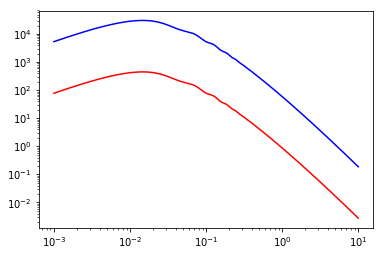

In [14]:
plt.figure('test Plin')
kk = np.logspace(-3,1,500)
plt.loglog(kk, PK.P(0.0, kk), color='b')
plt.loglog(kk, PK.P(99, kk), color='r')
plt.show()

In [ ]:
#np.savetxt('/Users/gev866/Downloads/plensz99.txt', (np.vstack((kk,PK.P(99, kk)))).T, fmt = '%1.8f')
np.savetxt('/Users/gev866/Downloads/plensz0.txt', (np.vstack((kk,PK.P(0.0, kk)))).T, fmt = '%1.8f')

In [15]:
#Camb Limber lensing
pars.set_for_lmax(5000, lens_potential_accuracy=1)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
pars.SourceWindows = [GaussianSourceWindow(redshift=1.0, source_type='lensing', sigma=0.001)]
results = camb.get_results(pars)
clslin = results.get_source_cls_dict()
ls=  np.arange(2, 5000+1)

In [16]:
pars.set_cosmology(H0=72.0, ombh2=0.0456*0.72*0.72, omch2=(0.638-0.0456)*0.72*0.72)
pars.InitPower.set_params(ns=0.965, As=Astemp)
resultsup = camb.get_results(pars)
print('Temporary sigma8=', resultsup.get_sigma8())
sig8 = 0.25
Asnew = Astemp*(sig8/resultsup.get_sigma8())**2
pars.InitPower.set_params(ns=0.965, As=Asnew)
resultsup = camb.get_results(pars)
print('New sigma8=', resultsup.get_sigma8())

Temporary sigma8= [1.50435714]
New sigma8= [0.25]


In [17]:
clsup = resultsup.get_source_cls_dict()

In [21]:
#cosmotr = pyccl.Cosmology(Omega_c=0.26-0.046, Omega_b=0.26-0.046, h=0.72, sigma8=0.8, n_s=0.96, transfer_function='bbks')
cosmotr = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='bbks', matter_power_spectrum='emu')
cosmofit = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='bbks', matter_power_spectrum='halofit')
import math
# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0.99, 1.01, 10)
n = np.ones(z_n.shape)
#z_n = np.array([1.0])
#n = np.ones(z_n.shape)

# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = pyccl.WeakLensingTracer(cosmotr, dndz=(z_n, n))
lens2 = pyccl.WeakLensingTracer(cosmotr, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
#ell = np.arange(2, 5000)
ell = np.linspace(150, 5000, 50)
#ell = l
cls = pyccl.angular_cl(cosmotr, lens1, lens2, ell)

z_n = np.linspace(0.99, 1.01, 20)
n = np.ones(z_n.shape)
lens1f = pyccl.WeakLensingTracer(cosmofit, dndz=(z_n, n))
lens2f = pyccl.WeakLensingTracer(cosmofit, dndz=(z_n, n))
clsfit = pyccl.angular_cl(cosmofit, lens1f, lens2f, ell)
#print(cls)

In [27]:
rz = pyccl.background.angular_diameter_distance(cosmotr, 1.0/(1.0+1.0), a2=None)
print (l,(l+0.2)/rz, rz)

[ 174.24242424  322.72727273  471.21212121  619.6969697   768.18181818
  916.66666667 1065.15151515 1213.63636364 1362.12121212 1510.60606061
 1659.09090909 1807.57575758 1956.06060606 2104.54545455 2253.03030303
 2401.51515152 2550.         2698.48484848 2846.96969697 2995.45454545
 3143.93939394 3292.42424242 3440.90909091 3589.39393939 3737.87878788
 3886.36363636 4034.84848485 4183.33333333 4331.81818182 4480.3030303
 4628.78787879 4777.27272727 4925.75757576] [0.10598683 0.19620249 0.28641815 0.37663381 0.46684947 0.55706513
 0.64728079 0.73749645 0.82771211 0.91792777 1.00814343 1.09835909
 1.18857476 1.27879042 1.36900608 1.45922174 1.5494374  1.63965306
 1.72986872 1.82008438 1.91030004 2.0005157  2.09073136 2.18094702
 2.27116268 2.36137834 2.451594   2.54180966 2.63202532 2.72224098
 2.81245664 2.9026723  2.99288796] 1645.8877302220524


In [28]:
#ClavgG

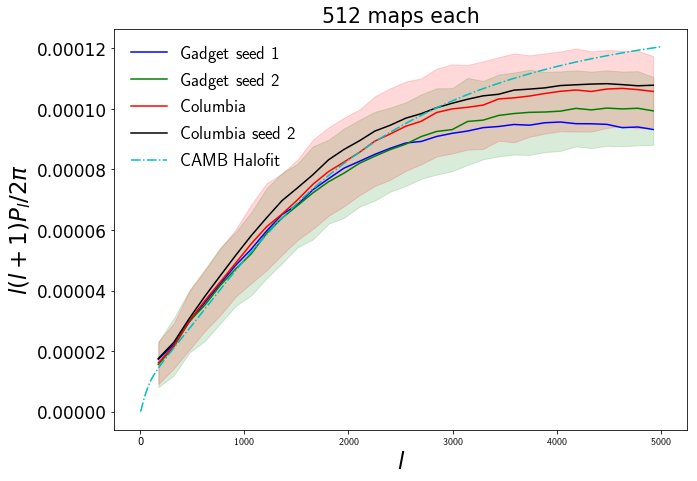

In [29]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')

ax.errorbar(l, ClavgG1800, label=r"Gadget seed 1", color='b')
#ax.fill_between(l,(ClavgG1800-CerrG1800), (ClavgG1800+CerrG1800), color='b', alpha=0.15)
ax.errorbar(l, ClavgG, label=r"Gadget seed 2", color='g')
ax.fill_between(l,(ClavgG-CerrG), (ClavgG+CerrG), color='g', alpha=0.15)
#ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
#ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt, label="Columbia", color='r')
ax.fill_between(lzolt,(ClZolt-CerrZolt), (ClZolt+CerrZolt), color='r', alpha=0.15)

ax.errorbar(lzolt, ClZoltseed2, label="Columbia seed 2", color='k')
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)

#ax.errorbar(l, Clavg, label="COLA", color='c', linestyle = ':')
#ax.fill_between(l,(Clavg-Cerr), (Clavg+Cerr), color='c', alpha=0.1)
#ax.errorbar(ell, ell*(ell+1)*cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, ell*(ell+1)*clsfit/(2*math.pi), label="Halofit", color='g', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1], label="CAMB Halofit", color='c', linestyle='-.')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.title('512 maps each')
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$l(l+1)P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
#plt.xlim(150, 2000)
plt.tight_layout()
#plt.savefig('./Cl_compnew.png')
plt.show()

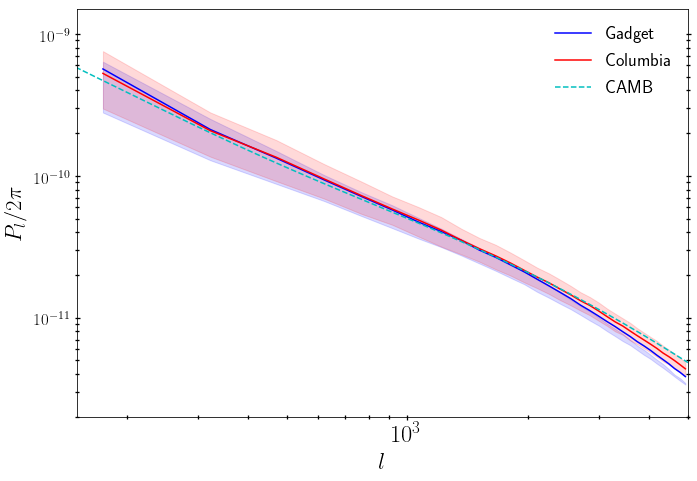

In [30]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')
ax.errorbar(l, ClavgG1800/l/(l+1), label="Gadget", color='b')
ax.fill_between(l,(ClavgG1800-CerrG1800)/l/(l+1), (Clavg+Cerr)/l/(l+1), color='b', alpha=0.15)

#ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
#ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt/l/(l+1), label="Columbia", color='r')
ax.fill_between(lzolt,(ClZolt-CerrZolt)/l/(l+1), (ClZolt+CerrZolt)/l/(l+1), color='r', alpha=0.15)
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)
#ax.errorbar(ell, cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, clsfit/(2*math.pi), label="Halofit", color='c', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1]/ls/(ls+1), label="CAMB", color='c', linestyle='--')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
plt.xlim(150, 5000)
plt.ylim(2e-12, 1.5e-9)
plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
plt.tick_params(which='both',width=1.3)
plt.tight_layout()
plt.savefig('./Cl_complog.png')
plt.show()

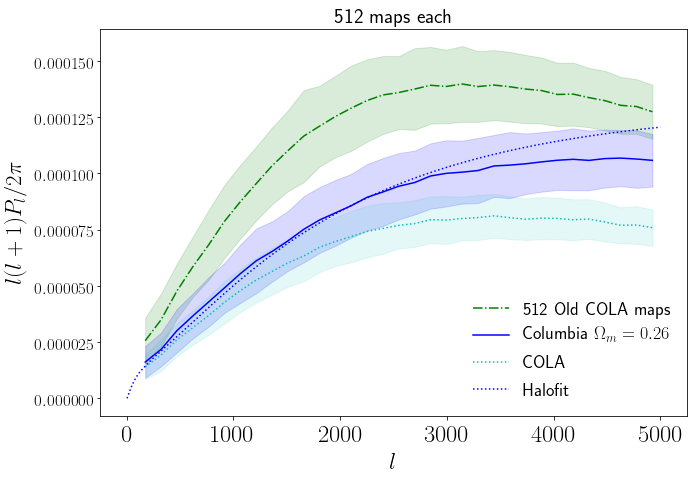

In [36]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')

#ax.errorbar(l, ClavgG1800, label=r"Gadget $1800^3$ grid", color='b')
#ax.fill_between(l,(ClavgG1800-CerrG1800), (ClavgG1800+CerrG1800), color='b', alpha=0.15)
#ax.errorbar(l, ClavgG, label=r"Gadget $512^3$ grid", color='g')
#ax.fill_between(l,(ClavgG-CerrG), (ClavgG+CerrG), color='m', alpha=0.15)
ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt, label=r"Columbia $\Omega_m=0.26$", color='b')
ax.fill_between(lzolt,(ClZolt-CerrZolt), (ClZolt+CerrZolt), color='b', alpha=0.15)
#ax.errorbar(lzolt2, ClZolt2, label="Columbia", color='r')
#ax.fill_between(lzolt2,(ClZolt2-CerrZolt2), (ClZolt2+CerrZolt2), color='r', alpha=0.15)
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)

ax.errorbar(l, Clavg, label="COLA", color='c', linestyle = ':')
ax.fill_between(l,(Clavg-Cerr), (Clavg+Cerr), color='c', alpha=0.1)
#ax.errorbar(ell, ell*(ell+1)*cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, ell*(ell+1)*clsfit/(2*math.pi), label="Halofit", color='g', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1], label='Halofit', color='b', linestyle=':')
#ax.errorbar(ls, clsup['W1xW1'][2:5000+1], label=r"$\Omega_m=0.638$", color='r', linestyle='-.')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.title('512 maps each')
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$l(l+1)P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
#plt.xlim(150, 2000)
#plt.ylim(1e-7, 4e-5)
plt.tight_layout()
#plt.savefig('./Cl_compnew.png')
plt.show()

In [32]:
h=0.72
kemu, PkEmu = np.loadtxt('/Users/gev866/Downloads/CosmicEmu/P_tot/EMU0.txt', unpack=True)
from scipy.interpolate import interp1d
Pfit = interp1d(kemu, PkEmu*h*h*h, kind='cubic')
Pfit2 = interp1d(kemu*h, PkEmu, kind='cubic')
kCOLA, PkCOLA = np.loadtxt('/Users/gev866/Downloads/Pkz0_COLA.txt', unpack=True)
#print (kCOLA/h,Pfit(kCOLA)/PkCOLA-1,Pfit(kCOLA)/PkCOLAh-1)

kCOLAh, PkCOLAh = np.loadtxt('/Users/gev866/Downloads/Pkz0_COLA_100.txt', unpack=True)

klin, Plinlens = np.loadtxt('/Users/gev866/Downloads/plinlens.txt', unpack=True)
#print (kCOLA/h,PkCOLAh/PkCOLA)

In [ ]:
#PCOLAfit = interp1d(kCOLAh, PkCOLAh/h/h/h, kind='cubic')
count =0
aa=1
def Pfunc(k,a):
  pk_nl = pyccl.nonlin_matter_power(cosmofit, k, a)  
  print (k)
  return np.asarray(pk_nl)    
  #return Pfit2(k)
#Pfunc = np.vectorize(Pfunc)
Pobj2D = pyccl.pk2d.Pk2D(pkfunc = Pfunc, cosmo = cosmotr)

In [ ]:
zvalues = np.loadtxt('/Users/gev866/Downloads/zvalues.txt')

In [ ]:
zvalues[np.where(zvalues == 78.43282347242813)]

In [ ]:
for i in range(zvalues.shape[0]-2,zvalues.shape[0]):
    zz = zvalues[i]
    print (zz)

In [ ]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmolens = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))
a = 1./(1+z)
pk_lens = pyccl.nonlin_matter_power(cosmolens, kCOLA, 1.0)
pk_lens *= h*h*h


In [ ]:
print (kCOLA/h)

In [ ]:
aout = np.loadtxt('/Users/gev866/Downloads/outputs.txt')
zout = 1.0/aout - 1.0
#trc = pyccl.tracers.Tracer()
#tracer = pyccl.tracers.NumberCountsTracer(cosmolens, has_rsd=False, dndz=(zout, np.ones_like(zout)), bias=None, mag_bias=None)
#tracer1 = trc.add_tracer(cosmolens, kernel=None, transfer_ka=None, transfer_k=None, transfer_a=None, der_bessel=0, der_angles=0, is_logt=False, extrap_order_lok=0, extrap_order_hik=2)
#cllin = pyccl.cls.angular_cl(cosmolens, tracer, tracer, l, p_of_k_a=None, l_limber=-1, limber_integration_method='qag_quad')

In [ ]:
cosmolin = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='eisenstein_hu', matter_power_spectrum='linear')
pklin = pyccl.power.linear_matter_power(cosmolin, kemu, 1.0)
pklin *= h*h*h

In [ ]:
from matplotlib import gridspec
from matplotlib import cm
def applyPlotStylePk():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 #plt.grid(True)
 plt.xscale("log")
 #plt.yscale("log")
 plt.xlim(0.1, 3.60)
 plt.ylim(0, 700)
 #plt.ylim(11, 50000)
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 ax.set_xlabel(r"$k (h/Mpc)$", fontsize=23)
 ax.set_ylabel(r"$k P(k)$", fontsize=23)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})
def applyPlotStylesub():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 #plt.grid(True)
 plt.xscale("log")
 #plt.yscale("log")
 plt.xlim(0.1, 3.60)
 #plt.ylim(0, 700)
 plt.ylabel(r"$\frac{P_{COLA}}{P_{Emu}}-1$",fontsize=24)
 ax2.set_xlabel(r"$k (h/Mpc)$", fontsize=23)
 #ax2.set_ylabel(r"$P(k)$", fontsize=23)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=23)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

gs=gridspec.GridSpec(2,1, wspace=0.0, hspace=0.0, height_ratios=[5,4])
fig10=plt.figure('Pkcomp', figsize=(0.95*9, 0.94*11))
ax=fig10.add_subplot(gs[0,0])
applyPlotStylePk()
ax2=fig10.add_subplot(gs[1,0])
applyPlotStylesub()
ax.set_title(r' Comparison at $z=0.0$')
ax.errorbar(kemu/h, (kemu/h)*PkEmu*h*h*h, color='b',label='CosmicEmu')#, markersize='4'
#ax.errorbar(kCOLA/h, kCOLA/h*pk_lens, color='b',label='CosmicEmu')#,label='CosmicEmu')
ax.errorbar(kCOLA/h, (kCOLA/h)*PkCOLA, color='g', label='COLA 40 steps')
ax.errorbar(kCOLA/h, (kCOLA/h)*PkCOLAh, color='r', label='COLA 100 steps', linestyle='-.')
#ax.errorbar(kemu/h, (kemu/h)*pklin, color='c', linestyle=':',label='Linear')
#ax.errorbar(klin, klin*Plinlens, color='c', linestyle=':',label='CAMB')
ax.errorbar(klin, klin*PK.P(0.0,klin), color='c', linestyle=':',label='CAMB')
ax.legend(loc="best", frameon=False, numpoints=1, prop={'size':16})
plt.setp(ax.get_xticklabels(), visible=False)
ax2.errorbar(kCOLA/h, PkCOLA/pk_lens-1, color='g')
ax2.errorbar(kCOLA/h, PkCOLAh/pk_lens-1, color='r', linestyle='-.')
#ax.errorbar(kRSD, Pk0RSD, color='r', marker = '^', markersize='4', linestyle='-.', label='Redshift space')
plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':16})
plt.tight_layout()
plt.show()
#plt.savefig('./Pk_compnew.png')

In [ ]:
np.logspace(math.log(45,10), math.log(5000,10), 34)

In [ ]:
testlike = np.load('/Users/gev866/Downloads/arrays/epoch75_predvalloglike.npy')

In [ ]:
mvn = np.load('/Users/gev866/Downloads/arrays/mvn_val_loglike.npy')

In [ ]:
testlike[:,0].shape

In [ ]:
fig1 = plt.figure('testlike', figsize=(11, 8))
ax = fig1.add_subplot(111)
#ax.plot(Plmat[:,10], mvn_loglike, linestyle='None', marker='o')
#for i in range(Plmat.shape[1]):
#for i in range(9,10):    
#  ax.plot(Plmat[:,i]-Clavgfid[i], logvec[:,i]) 
#ax.set_xscale("log")
#ax.set_yscale("log")    
#ax.errorbar(l, mvn_loglike)
#ax.scatter(np.arange(testlike.shape[0]), testlike/(np.amin(testlike)))
#ax.scatter(np.arange(mvn.shape[0]), mvn/(np.amin(testlike)))
#ax.scatter(np.arange(testlike.shape[0]), testlike/(np.amin(testlike)))
ax.plot(np.arange(mvn.shape[0]), -mvn+testlike[:,0], linestyle='None', marker='o')
plt.show()